In [225]:
# pytorch models with folds
mnames = ['se_resnext_d10','se_resnext_d11','iv3_a3','iv3_a4','iv3_a5','iv3_a6',
          'resnet_a10','resnet_a11','resnet_a13','resnet_a15',
          'resnet_b15','resnet_b18',
          'nas_a7','irv2_a4','irv2_a6',
          'se_resnet_a18','se_resnet_b18','se_resnet_b22',
          'se_resnext_e11',
          'dpn_a0','dpn_a7','dpn_b6']
special = 'iv3_a6'
nfold = 4

In [226]:
import numpy as np
import pandas as pd
import pickle
import os
from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, Concatenate, concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Reshape, Lambda, Activation
from keras.layers import UpSampling2D, Dropout, BatchNormalization, MaxPooling2D
from keras.losses import binary_crossentropy
from keras import backend as K
from keras.applications import MobileNet

import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.morphology import opening, closing

from scipy.special import logit, expit
import scipy.optimize as opt
from sklearn.model_selection import StratifiedKFold

import gc
import cv2
from tqdm import tqdm_notebook

from sklearn.metrics import jaccard_similarity_score, f1_score

# from metrics import iou_metric, iou_metric_batch
# from metric import mean_iou

In [227]:
PATH_TO_TRAIN = './train/'
PATH_TO_TEST = './test/'
PATH_TO_TARGET = './train.csv'
PATH_TO_SUB = './sample_submission.csv'

LABEL_MAP = {
0: "Nucleoplasm" ,
1: "Nuclear membrane"   ,
2: "Nucleoli"   ,
3: "Nucleoli fibrillar center",   
4: "Nuclear speckles"   ,
5: "Nuclear bodies"   ,
6: "Endoplasmic reticulum"   ,
7: "Golgi apparatus"  ,
8: "Peroxisomes"   ,
9:  "Endosomes"   ,
10: "Lysosomes"   ,
11: "Intermediate filaments"  , 
12: "Actin filaments"   ,
13: "Focal adhesion sites"  ,
14: "Microtubules"   ,
15: "Microtubule ends"   ,
16: "Cytokinetic bridge"   ,
17: "Mitotic spindle"  ,
18: "Microtubule organizing center",  
19: "Centrosome",
20: "Lipid droplets"   ,
21: "Plasma membrane"  ,
22: "Cell junctions"   ,
23: "Mitochondria"   ,
24: "Aggresome"   ,
25: "Cytosol" ,
26: "Cytoplasmic bodies",
27: "Rods & rings"}

In [228]:
df = pd.read_csv(PATH_TO_TARGET)
df.set_index('Id',inplace=True)
print(df.head())
print(df.shape)

                                       Target
Id                                           
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0        5
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0        1
001838f8-bbca-11e8-b2bc-ac1f6b6435d0       18
(31072, 1)


In [229]:
file_list = list(df.index.values)

ss = pd.read_csv(PATH_TO_SUB)
ss.set_index('Id',inplace=True)
print(ss.head())
print(ss.shape)

                                      Predicted
Id                                             
00008af0-bad0-11e8-b2b8-ac1f6b6435d0          0
0000a892-bacf-11e8-b2b8-ac1f6b6435d0          0
0006faa6-bac7-11e8-b2b7-ac1f6b6435d0          0
0008baca-bad7-11e8-b2b9-ac1f6b6435d0          0
000cce7e-bad4-11e8-b2b8-ac1f6b6435d0          0
(11702, 1)


In [230]:
# train_df["images"] = [np.array(load_img("images/{}.png".format(idx), color_mode = "grayscale")) / 255 \
#                       for idx in tqdm_notebook(train_df.index)]

# train_df["masks"] = [np.array(load_img("masks/{}.png".format(idx), color_mode = "grayscale")) / 255 \
#                      for idx in tqdm_notebook(train_df.index)]

In [231]:
df.columns

Index(['Target'], dtype='object')

In [232]:
oof = df.copy()
# print(oof.head())
# print(oof.shape)
eps = 1e-6

for k,m in enumerate(mnames):
    # print(m),
    first = True
    for fold in range(nfold):
        idf, pooff, yooff = pickle.load(open('oof/'+m+'_'+str(fold)+'.pkl','rb'))
        # change to probability scale
        pooff = expit(pooff)
        
        # average in any replicates
        nx = 0
        for rep in ['a','b','c','d','e','f','g','h','i']:
            fname = 'oof/'+m+rep+'_'+str(fold)+'.pkl'
            if os.path.exists(fname):
                print('found replicate ' + fname + ' for ' + m)
                if m in three_baggers:
                    idfx, pooffx, logitx = pickle.load(open(fname,'rb'))
                    logitf += logitx
                else:
                    idfx, pooffx = pickle.load(open(fname,'rb'))
                  
                # change to probability scale
                pooffx = expit(pooffx)
                pooff += pooffx 
                nx = nx + 1
        if nx: pooff /= (nx+1.) 

        if first:
            id = idf
            poof = pooff.copy()
            yoof = yooff.copy()
            first = False
        else:
            id = id + idf
            poof = np.concatenate((poof,pooff))
            yoof = np.concatenate((yoof,yooff))
    
    mdf = pd.DataFrame({'Id':id})
    # print(poof.shape)
    if k==0: mdf['y'] = [yoof[i] for i in range(yoof.shape[0])]
    mdf[m] = [poof[i] for i in range(poof.shape[0])]
    mdf.set_index('Id',inplace=True)
    oof = oof.join(mdf)


In [233]:
# print(oof.head())
print(oof.shape)

(31072, 24)


In [234]:
oof.columns

Index(['Target', 'y', 'se_resnext_d10', 'se_resnext_d11', 'iv3_a3', 'iv3_a4',
       'iv3_a5', 'iv3_a6', 'resnet_a10', 'resnet_a11', 'resnet_a13',
       'resnet_a15', 'resnet_b15', 'resnet_b18', 'nas_a7', 'irv2_a4',
       'irv2_a6', 'se_resnet_a18', 'se_resnet_b18', 'se_resnet_b22',
       'se_resnext_e11', 'dpn_a0', 'dpn_a7', 'dpn_b6'],
      dtype='object')

In [235]:
vp = oof.loc[oof['y'].notnull()]
print(vp.shape)

(31072, 24)


In [236]:
vp.head()

,Target,y,se_resnext_d10,se_resnext_d11,iv3_a3,iv3_a4,iv3_a5,iv3_a6,resnet_a10,resnet_a11,...,nas_a7,irv2_a4,irv2_a6,se_resnet_a18,se_resnet_b18,se_resnet_b22,se_resnext_e11,dpn_a0,dpn_a7,dpn_b6
Id,,,,,,,,,,,,,,,,,,,,,
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.97631204, 0.00040827369, 0.027155839, 0.002...","[0.3902099, 0.0002638064, 0.0026036645, 0.0003...","[0.9891422, 6.656991e-05, 0.0013477312, 0.0003...","[0.40627512, 0.00090589176, 0.0013553868, 0.00...","[0.8239573, 0.00023192668, 0.009582425, 0.0020...","[0.23881483, 4.7133985e-06, 0.0017503233, 0.00...","[0.49014178, 0.10754361, 0.2720811, 0.19139074...","[0.41386524, 0.09576756, 0.28844136, 0.0747008...",...,"[0.99999774, 4.6615467e-10, 3.4605725e-07, 3.6...","[0.9150919, 0.0009935455, 0.15155481, 0.011927...","[0.9441595, 0.0001919169, 0.022507522, 0.00050...","[0.5821155, 3.1793573e-07, 0.0005105834, 8.202...","[0.31098336, 6.4377457e-07, 8.852516e-06, 5.21...","[0.9918834, 3.232981e-07, 1.6308877e-05, 1.594...","[0.7366756, 0.00059972814, 0.003290994, 0.0012...","[0.44752684, 0.0026241515, 0.005336848, 0.0005...","[0.7728552, 6.490296e-05, 1.4489156e-05, 1.419...","[0.1896649, 0.0009342494, 0.00086473586, 1.699..."
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.9521354, 0.9527805, 0.0019924014, 4.250244e...","[0.8342673, 0.9976215, 6.6813234e-05, 1.693680...","[0.7078934, 0.8210275, 0.0863061, 0.0353334, 0...","[0.27613226, 0.99382716, 0.1513784, 0.00552231...","[0.1841979, 0.9997899, 0.10534124, 0.001126670...","[0.7802134, 0.99731183, 0.18973923, 0.00180515...","[0.6304316, 0.5312503, 0.23735237, 0.1614804, ...","[0.58571404, 0.866836, 0.4812426, 0.10373016, ...",...,"[0.8822161, 0.99998224, 0.42744225, 0.00021715...","[0.7700987, 0.9785033, 0.40990007, 0.0399978, ...","[0.73280996, 0.92130387, 0.9701412, 0.00067955...","[0.9967463, 0.61745274, 0.98285484, 0.02495887...","[0.9953334, 0.9985536, 0.99331254, 0.000328142...","[0.99778783, 0.99985254, 0.9828677, 6.398943e-...","[0.9098575, 0.8040256, 0.0035695233, 5.78177e-...","[0.9206252, 0.6409931, 0.9673797, 0.0036114666...","[0.83509785, 0.6088871, 0.82174736, 0.00049790...","[0.5315946, 0.9996326, 0.99990976, 0.000108916..."
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.5020701, 0.0062458036, 0.025552707, 0.03773...","[0.46325088, 0.0016569613, 0.016555335, 0.0069...","[0.5760826, 0.0006748021, 0.0033273406, 0.0624...","[0.2884413, 0.004674611, 0.05430049, 0.0792048...","[0.80905807, 0.0015114062, 0.3456989, 0.615903...","[0.9392793, 0.0016193952, 0.5919029, 0.1871529...","[0.47297847, 0.113954246, 0.16074447, 0.449507...","[0.49674734, 0.06255102, 0.26781502, 0.1932950...",...,"[0.9935126, 7.240996e-07, 0.9220826, 0.0012048...","[0.5839344, 0.0020056465, 0.17583431, 0.460615...","[0.7437609, 0.0036200495, 0.12894857, 0.603494...","[0.9903351, 0.00057298824, 0.86397445, 0.05858...","[0.99911934, 0.0009379225, 0.9092788, 0.019548...","[0.9998677, 0.0017638305, 0.9878178, 0.0016283...","[0.39966783, 0.0019521557, 0.024693796, 0.0108...","[0.74704707, 0.0009578496, 0.08297252, 0.59388...","[0.7423774, 0.00036342928, 0.27006754, 0.76644...","[0.8873165, 0.0012255692, 0.71309763, 0.897055..."
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.98463815, 0.99956995, 9.431456e-05, 0.00033...","[0.8436162, 0.99856025, 0.0014307043, 0.000325...","[0.22251642, 0.9593693, 0.031344388, 0.0033644...","[0.03656807, 0.9976897, 0.013786195, 0.0005486...","[0.045751065, 0.9996164, 0.0020771865, 0.00029...","[0.12870792, 0.99676824, 0.003474811, 0.000910...","[0.5977819, 0.87700015, 0.13550837, 0.06767246...","[0.39042625, 0.78161925, 0.07551139, 0.0539259...",...,"[1.0902692e-05, 0.997306, 0.0018032556, 6.5597...","[0.4540487, 0.9993031, 0.0049931128, 0.0017085...","[0.0058404896, 0.99995494, 0.0012768296, 0.001...","[0.18527779

In [237]:
offset = 2
nm = vp.shape[1] - offset
print(offset, nm)

2 22


In [238]:
y = np.array([a for a in vp.y])
y.shape

(31072, 28)

In [239]:
ys = np.sum(y,axis=1)
print(ys.shape)
print(ys.min(),ys.mean(),ys.max())

(31072,)
1.0 1.6343331 5.0


In [240]:
c_val = np.sum(y,axis=0)
for k,v in LABEL_MAP.items():
    print(k,v, 'count', c_val[k],
             'prop', '%6.4f' % (c_val[k]/y.shape[0]))

0 Nucleoplasm count 12885.0 prop 0.4147
1 Nuclear membrane count 1254.0 prop 0.0404
2 Nucleoli count 3621.0 prop 0.1165
3 Nucleoli fibrillar center count 1561.0 prop 0.0502
4 Nuclear speckles count 1858.0 prop 0.0598
5 Nuclear bodies count 2513.0 prop 0.0809
6 Endoplasmic reticulum count 1008.0 prop 0.0324
7 Golgi apparatus count 2822.0 prop 0.0908
8 Peroxisomes count 53.0 prop 0.0017
9 Endosomes count 45.0 prop 0.0014
10 Lysosomes count 28.0 prop 0.0009
11 Intermediate filaments count 1093.0 prop 0.0352
12 Actin filaments count 688.0 prop 0.0221
13 Focal adhesion sites count 537.0 prop 0.0173
14 Microtubules count 1066.0 prop 0.0343
15 Microtubule ends count 21.0 prop 0.0007
16 Cytokinetic bridge count 530.0 prop 0.0171
17 Mitotic spindle count 210.0 prop 0.0068
18 Microtubule organizing center count 902.0 prop 0.0290
19 Centrosome count 1482.0 prop 0.0477
20 Lipid droplets count 172.0 prop 0.0055
21 Plasma membrane count 3777.0 prop 0.1216
22 Cell junctions count 802.0 prop 0.0258
23

In [241]:
# idx = range(28)
# loc = [LABEL_MAP[j] for j in idx]
# lb = [c_val[j]/y.shape[0] for j in idx]

# df = pd.DataFrame({'idx':idx, 'loc':loc, 'training':lb})
# fname = 'train_props.csv'
# df.to_csv(fname,index=False)
# print(fname)

In [242]:
# train_sum_vec = np.sum(np.stack(subm['target_vec'].values, 0), 0)
# _ = plt.bar(n_keys, [train_sum_vec[k] for k in n_keys])

In [243]:
ymean = np.mean(y,axis=0)
print(ymean)

[0.415 0.04  0.117 0.05  0.06  0.081 0.032 0.091 0.002 0.001 0.001 0.035 0.022 0.017 0.034 0.001
 0.017 0.007 0.029 0.048 0.006 0.122 0.026 0.095 0.01  0.265 0.011 0.   ]


In [244]:
w = 1.0/np.mean(y,axis=0)
np.set_printoptions(precision=4,linewidth=80,suppress=True)
print(w)

[   2.4115   24.7783    8.5811   19.9052   16.7234   12.3645   30.8254
   11.0106  586.2642  690.4889 1109.7142   28.4282   45.1628   57.8622
   29.1482 1479.6191   58.6264  147.9619   34.4479   20.9663  180.6512
    8.2266   38.7431   10.4796   96.4969    3.7764   94.7317 2824.727 ]


In [245]:
x = np.array([x for x in vp[special]])
x = np.clip(x,-20,20)
print(x.shape, x.min(), x.mean(), x.max())

(31072, 28) 0.0 0.060788814 1.0


/home/sasrdw/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


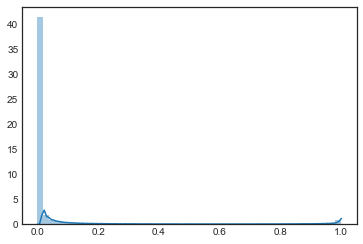

In [246]:
sns.distplot(x.flatten())

In [247]:
# t = -0.12
t = 0.2
xp = np.int32(x > t)
xps = np.sum(xp,axis=1)
print(xps.shape)
print(xps.min(),xps.mean(),xps.max())

(31072,)
0 2.16413491246138 6


In [248]:
print(np.mean(xp,axis=0))

[0.4983 0.0507 0.1395 0.0694 0.0735 0.1066 0.0511 0.0999 0.0011 0.0008 0.0003
 0.0482 0.0402 0.03   0.0441 0.0005 0.0346 0.0174 0.066  0.0735 0.0081 0.1578
 0.0522 0.1024 0.0152 0.3503 0.0321 0.0005]


In [249]:
# proportion of zero predictions
print(sum(xps==0)/x.shape[0])

0.004248197734294541


In [250]:
f1_score(y, xp, average='macro')

0.5433911143266726

In [251]:
# make sure every image has at least one prediction
x1 = x.copy()
for i in range(x.shape[0]):
    x1[i,np.argmax(x[i])] = 30

In [252]:
t = 0.4
x1p = np.int32(x1 > t)
x1ps = np.sum(x1p,axis=1)
print(x1ps.shape)
print(x1ps.min(),x1ps.mean(),x1ps.max())

(31072,)
1 1.6886907826982491 6


In [253]:
# proportion of zero predictions
print(sum(x1ps==0)/x1.shape[0])

0.0


In [254]:
f1_score(y, x1p, average='macro')

0.5696507981263289

In [255]:
# custom thresholds to match lb proportions
thresholds = np.linspace(5.0, -5., 1001)
pred = x.copy()
for j in range(pred.shape[1]):
    for t in thresholds:
        pred[:,j] = (x[:,j] > t).astype(int)
        prop = np.mean(pred[:,j])
        if prop >= ymean[j]: break
    print(j,'%6.4f' % t,'%6.4f' % ymean[j],'%6.4f' % prop, LABEL_MAP[j])
print(f1_score(y, pred, average='macro'))

0 0.4700 0.4147 0.4147 Nucleoplasm
1 0.5900 0.0404 0.0404 Nuclear membrane
2 0.3800 0.1165 0.1172 Nucleoli
3 0.4300 0.0502 0.0506 Nucleoli fibrillar center
4 0.4100 0.0598 0.0598 Nuclear speckles
5 0.3000 0.0809 0.0822 Nuclear bodies
6 0.4300 0.0324 0.0327 Endoplasmic reticulum
7 0.2700 0.0908 0.0915 Golgi apparatus
8 0.0200 0.0017 0.0017 Peroxisomes
9 0.0200 0.0014 0.0016 Endosomes
10 0.0000 0.0009 0.9977 Lysosomes
11 0.4600 0.0352 0.0353 Intermediate filaments
12 0.7200 0.0221 0.0222 Actin filaments
13 0.5400 0.0173 0.0173 Focal adhesion sites
14 0.6100 0.0343 0.0344 Microtubules
15 0.0300 0.0007 0.0008 Microtubule ends
16 0.4800 0.0171 0.0173 Cytokinetic bridge
17 0.8500 0.0068 0.0069 Mitotic spindle
18 0.5500 0.0290 0.0291 Microtubule organizing center
19 0.3400 0.0477 0.0484 Centrosome
20 0.4700 0.0055 0.0056 Lipid droplets
21 0.3400 0.1216 0.1224 Plasma membrane
22 0.6400 0.0258 0.0259 Cell junctions
23 0.2600 0.0954 0.0956 Mitochondria
24 0.6800 0.0104 0.0104 Aggresome
25 0.3500

In [256]:
# estimate thresholds by least squares, from lafoss kernel
# def sigmoid_np(x):
#     return 1.0/(1.0 + np.exp(-x))

# def F1_soft(preds,targs,th=0.5,d=50.0):
#     preds = sigmoid_np(d*(preds - th))
#     targs = targs.astype(np.float)
#     score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
#     return score

# def fit_val(x,y):
#     params = 0.5*np.ones(len(name_label_dict))
#     wd = 1e-5
#     error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
#                                       wd*(p - 0.5)), axis=None)
#     p, success = opt.leastsq(error, params, maxfev=10000)
#     return p

In [257]:
# pred = sigmoid_np(x)
# print(pred.min(),pred.mean(),pred.max())
# name_label_dict = LABEL_MAP
# th = fit_val(pred,y)
# th[th<0.1] = 0.1
# print('Thresholds: ',th)
# print('F1 macro: ',f1_score(y, pred>th, average='macro'))
# print('F1 macro (th = 0.5): ',f1_score(y, pred>0.5, average='macro'))
# print('F1 micro: ',f1_score(y, pred>th, average='micro'))

In [258]:
# pred = np.clip(x,-20,20)
# print(pred.min(),pred.mean(),pred.max())
# name_label_dict = LABEL_MAP
# th = fit_val(pred,y)
# # th[th<0.1] = 0.1
# print('Thresholds: ',th)
# print('F1 macro: ',f1_score(y, pred>th, average='macro'))
# print('F1 macro (th = 0.0): ',f1_score(y, pred>0.0, average='macro'))
# print('F1 micro: ',f1_score(y, pred>th, average='micro'))

In [259]:
# for i in range(len(th)):
#     print(i,np.round(th[i],decimals=2))

In [260]:
# print(np.mean(x > th,axis=0))

In [261]:
# f1_score(y, xp, average='samples')

In [262]:
f1_score(y, xp, average='micro')

0.6741904326165421

In [263]:
z = [(y,x) for y,x in zip(y,xp) if np.sum(x) == 0]
print(len(z))

132


In [264]:
# z[:5]

In [265]:
yz = np.array([t[0] for t in z])
xz = np.array([t[1] for t in z])
f1_score(yz,xz,average='macro')

0.0

0.0 0.684541178297615 1.0


/home/sasrdw/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


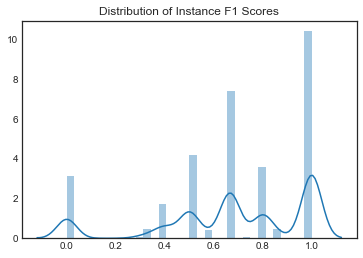

<Figure size 432x288 with 0 Axes>

In [266]:
f1b = np.array([f1_score(yi, xpi, average='binary') \
                 for yi,xpi in zip(y,xp)])
print(f1b.min(),f1b.mean(),f1b.max())
sns.distplot(f1b)
plt.title("Distribution of Instance F1 Scores")
plt.show()
plt.gcf().clear()

In [267]:
np.set_printoptions(precision=3, linewidth=100, suppress=True)
f = []
for m in mnames:
    f.append(np.array(list(vp[m])).flatten())
print(mnames)
r = np.corrcoef(f)
print(r)   

['se_resnext_d10', 'se_resnext_d11', 'iv3_a3', 'iv3_a4', 'iv3_a5', 'iv3_a6', 'resnet_a10', 'resnet_a11', 'resnet_a13', 'resnet_a15', 'resnet_b15', 'resnet_b18', 'nas_a7', 'irv2_a4', 'irv2_a6', 'se_resnet_a18', 'se_resnet_b18', 'se_resnet_b22', 'se_resnext_e11', 'dpn_a0', 'dpn_a7', 'dpn_b6']
[[1.    0.859 0.804 0.789 0.786 0.779 0.7   0.754 0.749 0.764 0.77  0.774 0.765 0.762 0.774 0.753
  0.763 0.752 0.857 0.777 0.766 0.687]
 [0.859 1.    0.807 0.859 0.813 0.805 0.705 0.77  0.758 0.765 0.786 0.79  0.777 0.776 0.791 0.753
  0.775 0.761 0.869 0.776 0.766 0.691]
 [0.804 0.807 1.    0.862 0.831 0.817 0.725 0.779 0.766 0.774 0.785 0.792 0.746 0.8   0.802 0.754
  0.77  0.755 0.78  0.782 0.764 0.707]
 [0.789 0.859 0.862 1.    0.841 0.828 0.716 0.784 0.764 0.767 0.79  0.797 0.754 0.79  0.807 0.75
  0.775 0.761 0.796 0.778 0.764 0.699]
 [0.786 0.813 0.831 0.841 1.    0.918 0.692 0.776 0.792 0.801 0.826 0.844 0.78  0.81  0.847 0.77
  0.799 0.784 0.793 0.81  0.791 0.744]
 [0.779 0.805 0.817 0.828

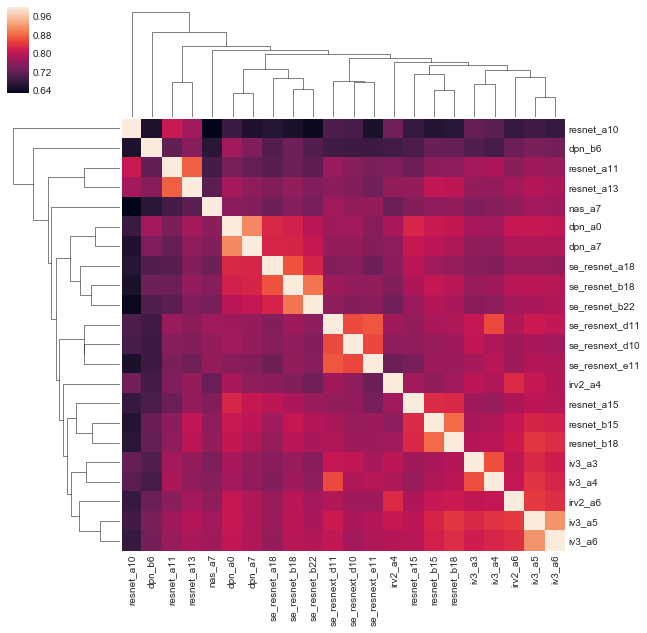

In [268]:
d = pd.DataFrame(r, columns=mnames)
d['id'] = mnames
d.set_index('id',inplace=True)
del d.index.name

sns.clustermap(d)


# import scipy.cluster.hierarchy as hc
# from matplotlib import pyplot
# link = hc.linkage(d.values, method='centroid')
# o1 = hc.leaves_list(link)

# mat = d.iloc[o1,:]
# mat = mat.iloc[:, o1[::-1]]
# pyplot.imshow(mat)

In [269]:
# # compute rank transform separately for every column
# from scipy.stats import rankdata
# n = vp.shape[0] * 28
# for m in mnames:
#     a = rankdata(np.array(list(vp[m])).flatten()).reshape((vp.shape[0],28))/n
#     vp[m] = [i for i in a]
# print(vp.shape)

In [270]:
# f = []
# for m in mnames:
#     f.append(np.array(list(vp[m])).flatten())
# print(mnames)
# print(np.corrcoef(f))   

In [271]:
print(f[0].min(),f[0].max())

1.1532587e-26 1.0


0 se_resnext_d10 0.45 0.5532


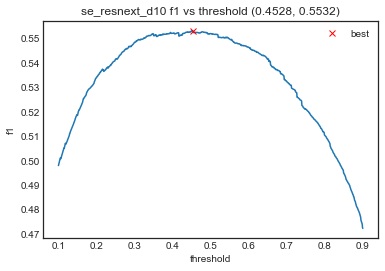

1 se_resnext_d11 0.27 0.5681


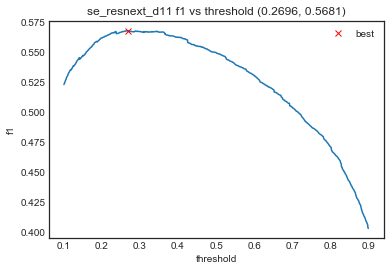

2 iv3_a3 0.51 0.5549


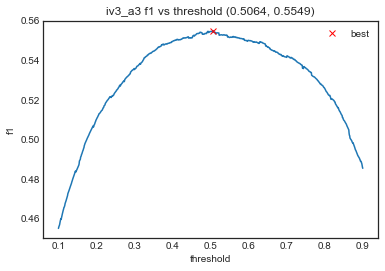

3 iv3_a4 0.32 0.5628


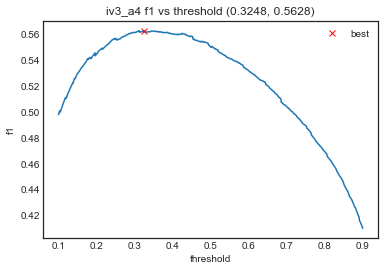

4 iv3_a5 0.52 0.5752


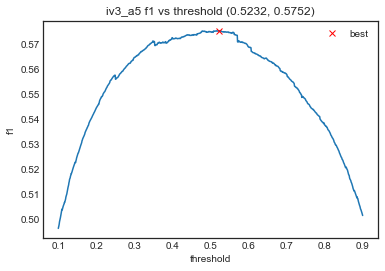

5 iv3_a6 0.51 0.5759


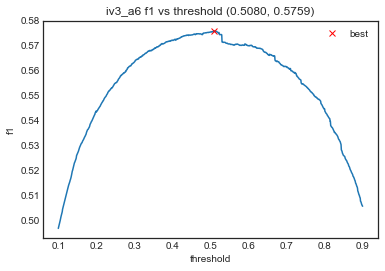

6 resnet_a10 0.46 0.4698


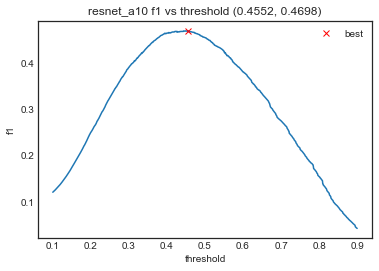

7 resnet_a11 0.49 0.5721


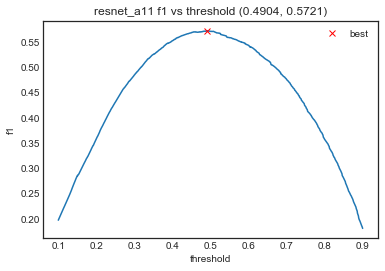

8 resnet_a13 0.46 0.5686


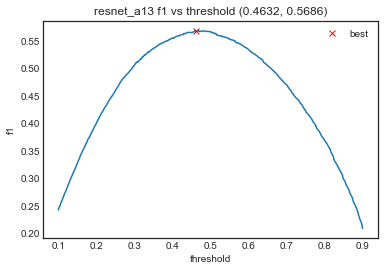

9 resnet_a15 0.53 0.5550


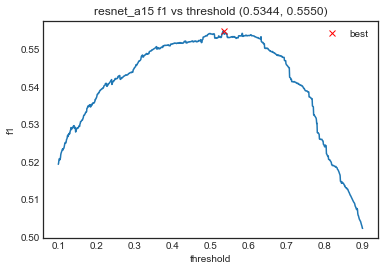

10 resnet_b15 0.40 0.5999


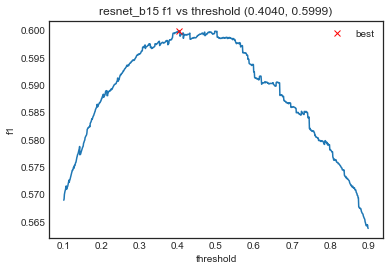

11 resnet_b18 0.50 0.5951


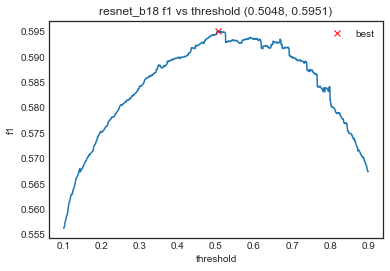

12 nas_a7 0.50 0.5565


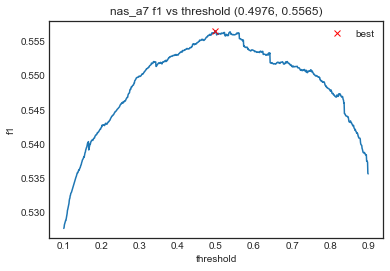

13 irv2_a4 0.43 0.4878


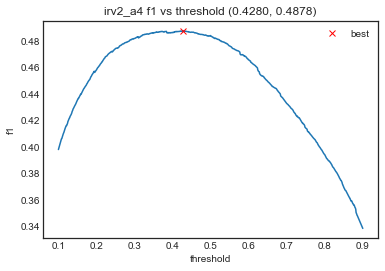

14 irv2_a6 0.51 0.5925


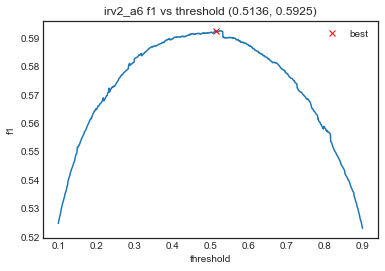

15 se_resnet_a18 0.42 0.5425


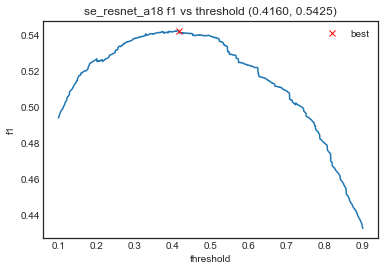

16 se_resnet_b18 0.46 0.6031


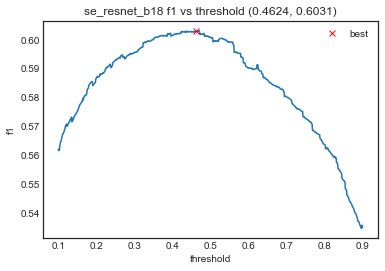

17 se_resnet_b22 0.36 0.6010


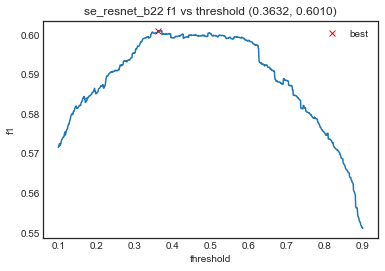

18 se_resnext_e11 0.51 0.6130


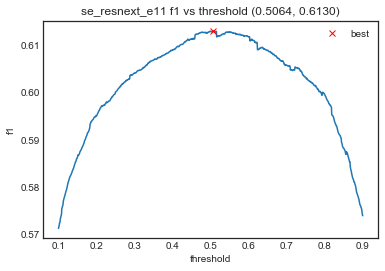

19 dpn_a0 0.44 0.5378


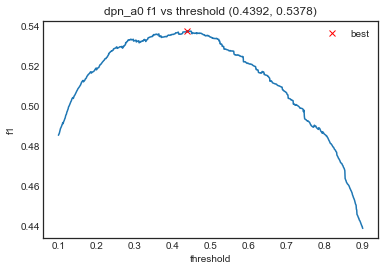

20 dpn_a7 0.29 0.5536


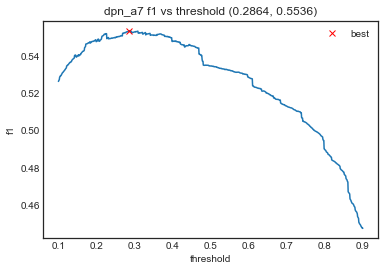

21 dpn_b6 0.90 0.5335


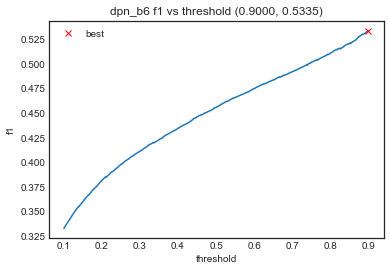

{'se_resnext_d10': 0.4528, 'se_resnext_d11': 0.2696, 'iv3_a3': 0.5064000000000001, 'iv3_a4': 0.3248, 'iv3_a5': 0.5232, 'iv3_a6': 0.508, 'resnet_a10': 0.45520000000000005, 'resnet_a11': 0.49040000000000006, 'resnet_a13': 0.46320000000000006, 'resnet_a15': 0.5344, 'resnet_b15': 0.404, 'resnet_b18': 0.5048, 'nas_a7': 0.49760000000000004, 'irv2_a4': 0.42800000000000005, 'irv2_a6': 0.5136000000000001, 'se_resnet_a18': 0.41600000000000004, 'se_resnet_b18': 0.46240000000000003, 'se_resnet_b22': 0.36319999999999997, 'se_resnext_e11': 0.5064000000000001, 'dpn_a0': 0.43920000000000003, 'dpn_a7': 0.2864, 'dpn_b6': 0.9}


<Figure size 432x288 with 0 Axes>

In [272]:
# model-specific global thresholds
# compute best single logit threshold for computed ensemble

# for probabilities
thresholds = np.linspace(0.1, 0.9, 1001)

# for logits
# thresholds = np.linspace(-1, 1, 101)

# for ranks
# thresholds = np.linspace(0.9, 1, 101)

# thresholds = [-0.4]

fname = 'mthresh.pkl'
# if os.path.isfile(fname): mthresh = pickle.load(open(fname,'rb'))
# else: mthresh = {}
mthresh = {}

for i in range(nm):
# for i in [3]:

    mname = vp.columns[i+offset]
    tv = np.array(list(vp.iloc[:,offset+i].values))

    # if mname in mthresh or np.sum(np.isnan(tv)) > 0: continue

    scores = np.array([f1_score(y, np.int32(tv > threshold),
                                 average='macro') for threshold in thresholds])

    besta = np.argmax(scores)
    threshold_best = thresholds[besta]
    score_best = scores[besta]
    print(i, mname, "%4.2f" % threshold_best, "%6.4f" % score_best)
    mthresh[mname] = threshold_best
    
    plt.plot(thresholds, scores)
    plt.plot(threshold_best, score_best, "xr", label="best")
    plt.xlabel("threshold")
    plt.ylabel("f1")
    plt.title(mname + " f1 vs threshold (%6.4f, %6.4f)" % (threshold_best, score_best))
    plt.legend()
    plt.show()
    plt.gcf().clear()

pickle.dump(mthresh,open(fname,'wb'))
print(mthresh)

In [273]:
vp.columns

Index(['Target', 'y', 'se_resnext_d10', 'se_resnext_d11', 'iv3_a3', 'iv3_a4',
       'iv3_a5', 'iv3_a6', 'resnet_a10', 'resnet_a11', 'resnet_a13',
       'resnet_a15', 'resnet_b15', 'resnet_b18', 'nas_a7', 'irv2_a4',
       'irv2_a6', 'se_resnet_a18', 'se_resnet_b18', 'se_resnet_b22',
       'se_resnext_e11', 'dpn_a0', 'dpn_a7', 'dpn_b6'],
      dtype='object')

In [274]:
# # model- and class-specific thresholds
# # compute best logit threshold for computed ensemble

# # thresholds = np.linspace(-2, 2, 101)

# # thresholds = [-0.4]

# fname = 'cthresh.pkl'
# # if os.path.isfile(fname): cthresh = pickle.load(open(fname,'rb'))
# cthresh = {}

# for i in range(nm):
# # for i in [2]:

#     mname = vp.columns[i+offset]
#     tv = np.array(list(vp.iloc[:,offset+i].values))

#     fm = [[f1_score(y[:,j], (tv[:,j] > t).astype(int)) \
#            for t in thresholds] for j in range(y.shape[1])]
    
#     besti = [np.argmax(f) for f in fm]
#     bestt = [thresholds[b] for b in besti]
#     bests = [f[b] for f,b in zip(fm,besti)]
#     print(mname, np.mean(bests))
    
#     td = {}
#     for j in range(y.shape[1]):
#         # print()
#         # print(j, LABEL_MAP[j], "%4.2f" % bestt[j], "%6.4f" % bests[j])
        
#         # print(j, "%4.2f" % bestt[j], "%6.4f" % bests[j], LABEL_MAP[j])
        
#         # print(cm[j], '%4.2f' % fm[j])
#         # print('')
#         td[j] = np.round(bestt[j],decimals=2)
    
#     cthresh[mname] = td
#     print()
    
# pickle.dump(cthresh,open(fname,'wb'))
# # print(mthresh)
# print(fname)

In [275]:
# mthresh['irv2_a2']

using f1 threshold 0.36
model 0 f1 for se_resnext_d10 = 0.5509
model 1 f1 for se_resnext_d11 = 0.5671
model 2 f1 for iv3_a3 = 0.5460
model 3 f1 for iv3_a4 = 0.5621
model 4 f1 for iv3_a5 = 0.5697
model 5 f1 for iv3_a6 = 0.5694
model 6 f1 for resnet_a10 = 0.4436
model 7 f1 for resnet_a11 = 0.5305
model 8 f1 for resnet_a13 = 0.5409
model 9 f1 for resnet_a15 = 0.5501
model 10 f1 for resnet_b15 = 0.5978
model 11 f1 for resnet_b18 = 0.5878
model 12 f1 for nas_a7 = 0.5519
model 13 f1 for irv2_a4 = 0.4866
model 14 f1 for irv2_a6 = 0.5874
model 15 f1 for se_resnet_a18 = 0.5414
model 16 f1 for se_resnet_b18 = 0.6009
model 17 f1 for se_resnet_b22 = 0.6006
model 18 f1 for se_resnext_e11 = 0.6072
model 19 f1 for dpn_a0 = 0.5357
model 20 f1 for dpn_a7 = 0.5515
model 21 f1 for dpn_b6 = 0.4250
step = 0   index = 18   name = se_resnext_e11    f1 = 0.6072
    try 0 se_resnext_d10 0.6065
    try 1 se_resnext_d11 0.6155
    try 2 iv3_a3 0.6380
    try 3 iv3_a4 0.6631
    try 4 iv3_a5 0.6414
    try 5 iv3_

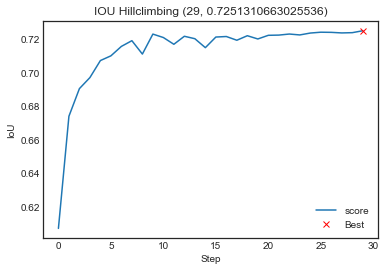

    step  midx     score             mod      f1_0
0      0    18  0.607192  se_resnext_e11  0.607192
1      1    17  0.674095   se_resnet_b22  0.600615
2      2     7  0.690599      resnet_a11  0.530497
3      3    12  0.697182          nas_a7  0.551936
4      4    14  0.707350         irv2_a6  0.587423
5      5    18  0.710157  se_resnext_e11  0.607192
6      6    16  0.715796   se_resnet_b18  0.600886
7      7     4  0.719201          iv3_a5  0.569710
8      8     3  0.711215          iv3_a4  0.562121
9      9    18  0.723133  se_resnext_e11  0.607192
10    10     6  0.721081      resnet_a10  0.443578
11    11    21  0.717051          dpn_b6  0.424971
12    12    12  0.721836          nas_a7  0.551936
13    13     6  0.720379      resnet_a10  0.443578
14    14    17  0.715039   se_resnet_b22  0.600615
15    15    18  0.721373  se_resnext_e11  0.607192
16    16    10  0.721688      resnet_b15  0.597819
17    17    18  0.719463  se_resnext_e11  0.607192
18    18     5  0.722161       

<Figure size 432x288 with 0 Axes>

In [276]:
# oof = small

# hillclimbing
# vp = oof.copy()
# offset = 5
# nm = vp.shape[1] - offset
nr = vp.shape[0]
y = np.array([y for y in vp.y])
# y = np.array(list(vp['masks'].values))
nstep = 30

step0fix = -1
# step0fix = 5
step1fix = -1

intercept = 0
rez = pd.DataFrame({'step':np.zeros(nstep).astype(int),'midx':np.zeros(nstep).astype(int),
                    'score':np.zeros(nstep)})
currEnsemble = 0 * np.array(list(vp.iloc[:,offset].values))

metric = 'f1'
# metric = 'iou'

# using model-specific thresholds below so set global to 0
# threshold = 0.
# threshold = -0.4
threshold = 0.36

print('using ' + metric + ' threshold',threshold)

# metric = "mcc"
# metric = "corr"
# metric = "rmse"
# metric = "mse"
# metric = "mae"
# metric = "winsorized_mae"
# metric = "auc"

# maximizing
bestScore = -9999999
single = pd.DataFrame({'mod':np.repeat("",nm)})
start = 0
for step in range(start,nstep):
    single[metric+'_'+str(step)] = np.nan

for step in range(start,nstep):
    currIndex = 0
    currScore = -9999999

    for i in range(nm):

        mname = vp.columns[i+offset]
        
        tv = np.array(list(vp.iloc[:,offset+i].values))

        # adjust by model-specific threshold
#         tv = tv - mthresh[mname]
        
        # adjust by model-class-specific thresholds
#         for j in range(tv.shape[1]):
#             tv[:,j] = tv[:,j] - cthresh[mname][j]

        if np.sum(np.isnan(tv)) > 0: continue
            
        if step==0:
            tryEnsemble = tv
        else:
            # running mean
            tryEnsemble = (step * currEnsemble + tv)/(step+1)
            # full matrix
            # choose median or mean here
            # tryEnsemble = rowMedians(cbind(currEnsemble,tv))
            # tryEnsemble = rowMeans(cbind(currEnsemble,tv))
            # quantiles are a lot slower
            # tryEnsemble = rowQuantiles(cbind(currEnsemble,tv),probs=0.6)

        if metric=="f1":
            tryScore = f1_score(y, np.int32(tryEnsemble > threshold),
                                average='macro')
            if step > 0: print('    try',i,mname,"%6.4f" % tryScore)
        elif metric=="iou":
            tryScore = iou_metric_batch(y, np.int32(tryEnsemble > threshold),
                                        pred_eps=pred_eps)
            if step > 0: print('    try',i,mname,"%6.4f" % tryScore)
        elif metric=="mse":
            tryScore = -mse(y,tryEnsemble)
        elif metric=="mae": 
            tryScore = -mae(y,tryEnsemble)
        elif metric=="winsorized_mae": 
            tryScore = -winsorized_mae(y,tryEnsemble+intercept)
        elif metric=="rmse":
            tryScore = -rmse(y,tryEnsemble)
        elif metric=="corr":
            tryScore = cor(y,tryEnsemble)
        elif metric=="mcc":
            opt = eval_mcc3(y,tryEnsemble,cut=T)
            tryScore = opt[1]
            cut = opt[2]
            # opt = optimize(mcc,c(0.1,0.3),tryEnsemble,vp$y,maximum=T)
            # tryScore = opt$objective
        elif metric=="logloss":
            # tryScore = -logLoss(vp$y,tryEnsemble,)
            tryScore = -eval_logloss2(tryEnsemble,y)
        elif metric=="auc":
            tryScore = auc2(y,tryEnsemble)
        elif metric=="auprc":
            tryScore = auprc(tryEnsemble, y)
            # tryScore = pr.curve(scores.class0 = tryEnsemble, weights.class0 = vp$y)$auc.integral
            # tryScore = pr.curve(scores.class0 = tryEnsemble, weights.class0 = vp$y)$auc.davis.goadrich
        elif metric=="aurocpr":
            auroc = auc(y,tryEnsemble)
            # auprc = pr.curve(scores.class0 = tryEnsemble, weights.class0 = vp$y)$auc.integral
            tryScore = (auroc + auprc)/2
        elif metric=="sqwk":
            tryScore = sqwk(y,tryEnsemble,1,8)
        
        ok = 1
        if (step==0) and (step0fix>-1) and (i!=step0fix): ok = 0 
        if (step==1) and (step1fix>-1) and (i!=step1fix): ok = 0 

        if (tryScore > currScore) and (ok==1):
            currIndex = i
            currScore = tryScore
            if (step==0):
                saveEnsemble = tv.copy()
            else:
                # running mean
                saveEnsemble = tryEnsemble.copy()
                # save whole matrix
                # saveEnsemble = np.concatenate((currEnsemble,tv),axis=1)
            if metric=="mcc": currCut = cut

        # if (step==0) or ((step==1) and (step0fix>-1)) or ((step==2) and (step1fix>-1)):
        if (step==0):
            if (metric=="mcc"):
                print("model",i,metric,"for",vp.columns[i+offset],"=",tryScore,"  cut =",cut,"\n")
            else:
                print("model",i,metric,"for",vp.columns[i+offset],"= %6.4f" % tryScore)

        if step==0:
            single.loc[i,'mod'] = vp.columns[i+offset]  
        single.iloc[i,step+1] = tryScore

    if metric=="mcc":
        print("step =",step,"  index =",currIndex,"  name =", vp.columns[currIndex+offset],"  ",
            metric,"= %6.4f" % currScore,"  cut =",currCut)
    else:
        print("step =",step,"  index =",currIndex,"  name =", vp.columns[currIndex+offset],"  ",
            metric,"= %6.4f" % currScore)

    currEnsemble = saveEnsemble.copy()
    if currScore > bestScore:
        bestScore = currScore
        bestStep = step
        bestEnsemble = currEnsemble.copy()
        if metric=="mcc": bestCut = currCut

    rez.iloc[step,0] = step
    rez.iloc[step,1] = currIndex
    rez.iloc[step,2] = currScore

if (metric=="mcc"):
    print("best step =",bestStep,"  best",metric,"=",bestScore,"  best cut =",bestCut)
else:
    print("best step =",bestStep,"  best",metric,"=",bestScore)

rez0 = rez.copy()

# tb = table(rez$index[1:bestStep])
# names(tb) = names(vp)[(offset+1):ncol(vp)][as.integer(names(table(rez$index[1:bestStep])))]

# if (intercept!=0) {
#   tb["Intercept"] = intercept
# }

# print(tb[order(-tb)])
# print(single[order(-single[,2]),][1:min(nrow(single),40),])

# plot hillclimbing
print('')
plt.plot(rez0.step, rez0.score)
plt.plot(bestStep, bestScore, "xr", label="Best")
plt.xlabel("Step")
plt.ylabel("IoU")
plt.title("IOU Hillclimbing ({}, {})".format(bestStep, bestScore))
plt.legend()
plt.show()
plt.gcf().clear()

# display the weights
rez = rez.iloc[:(bestStep+1)]
# print(rez)

single0 = single.iloc[:,:2]

rez['midx'] = rez['midx'].astype(int)
rez = rez.join(single0,how='left',on='midx')
print(rez)
print('')

rez['weight'] = 1
tb = rez.loc[:,['midx','weight']].groupby('midx').count()
# print(tb)
# print(single)

tb = tb.join(single0,how='left')
print(tb)


score_best 0.7251777074719807
threshold_best 0.3608



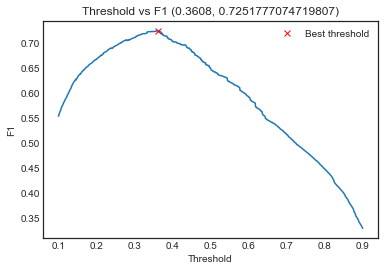

               mod   mean_f1
16   se_resnet_b18  0.707527
3           iv3_a4  0.707362
14         irv2_a6  0.707035
10      resnet_b15  0.706973
11      resnet_b18  0.706544
4           iv3_a5  0.705345
17   se_resnet_b22  0.705328
8       resnet_a13  0.705033
2           iv3_a3  0.705003
7       resnet_a11  0.704867
1   se_resnext_d11  0.704149
5           iv3_a6  0.703643
18  se_resnext_e11  0.703383
9       resnet_a15  0.703060
0   se_resnext_d10  0.702217
20          dpn_a7  0.701800
6       resnet_a10  0.701687
13         irv2_a4  0.701167
15   se_resnet_a18  0.700905
19          dpn_a0  0.700746
12          nas_a7  0.700175
21          dpn_b6  0.694265


<Figure size 432x288 with 0 Axes>

In [277]:
# tb = table(rez$index[1:bestStep])
# names(tb) = names(vp)[(offset+1):ncol(vp)][as.integer(names(table(rez$index[1:bestStep])))]

# if (intercept!=0) {
#   tb["Intercept"] = intercept
# }

# print(tb[order(-tb)])
# print(single[order(-single[,2]),][1:min(nrow(single),40),])

# # plot hillclimbing
# ggplot(data=rez, aes(x=step, y=score)) + 
#   geom_line(size=.75) + geom_point()   


# compute best threshold for computed ensemble
# thresholds = np.linspace(-2, 2, 41)
scores = np.array([f1_score(y, np.int32(bestEnsemble > threshold),
                        average='macro') for threshold in thresholds])
# ious = np.array([iou_metric_batch(train_df.masks, np.int32(bestEnsemble > threshold), \
#                                   pred_eps=pred_eps) for threshold in thresholds])

# threshold_best_index = np.argmax(ious[9:-10]) + 9
threshold_best_index = np.argmax(scores)
score_best = scores[threshold_best_index]
threshold_best = thresholds[threshold_best_index]
print('')
print('score_best',score_best)
print('threshold_best',threshold_best)
print('')

plt.plot(thresholds, scores)
plt.plot(threshold_best, score_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.title("Threshold vs F1 ({}, {})".format(threshold_best, score_best))
plt.legend()
plt.show()
plt.gcf().clear()

single['mean_'+metric] = single.iloc[:,1:].mean(axis=1)
single.sort_values('mean_'+metric,ascending=False,inplace=True)
print(single.loc[:,['mod','mean_'+metric]])

In [278]:
# error analysis
from sklearn.metrics import confusion_matrix

cm = [confusion_matrix(y[:,i], (bestEnsemble[:,i]  > threshold_best).astype(int)) \
       for i in range(y.shape[1])]
fm = [f1_score(y[:,i], (bestEnsemble[:,i]  > threshold_best).astype(int)) \
       for i in range(y.shape[1])]

print('macro f1','%6.4f' % np.mean(fm))
print()

# sort from worst to best
order = np.array(fm).argsort()
ymean = np.mean(y,axis=0)

for i in range(y.shape[1]):
    oi = order[i]
    print('class', '%2d' % oi,'  prop', '%6.4f' % ymean[oi], 
                     '  f1', '%6.4f' % fm[oi], '  ', LABEL_MAP[oi])
    print(cm[oi])
    print()

macro f1 0.7252

class 16   prop 0.0171   f1 0.5443    Cytokinetic bridge
[[30406   136]
 [  281   249]]

class 18   prop 0.0290   f1 0.5854    Microtubule organizing center
[[29842   328]
 [  393   509]]

class 17   prop 0.0068   f1 0.5885    Mitotic spindle
[[30801    61]
 [   97   113]]

class 26   prop 0.0106   f1 0.5911    Cytoplasmic bodies
[[30643   101]
 [  148   180]]

class  6   prop 0.0324   f1 0.6270    Endoplasmic reticulum
[[29629   435]
 [  349   659]]

class 22   prop 0.0258   f1 0.6276    Cell junctions
[[29935   335]
 [  282   520]]

class 20   prop 0.0055   f1 0.6341    Lipid droplets
[[30876    24]
 [   81    91]]

class 19   prop 0.0477   f1 0.6515    Centrosome
[[29110   480]
 [  534   948]]

class  5   prop 0.0809   f1 0.6826    Nuclear bodies
[[27959   600]
 [  900  1613]]

class 13   prop 0.0173   f1 0.6860    Focal adhesion sites
[[30392   143]
 [  182   355]]

class 21   prop 0.1216   f1 0.6975    Plasma membrane
[[26151  1144]
 [ 1142  2635]]

class 25   pro

In [279]:
np.mean(fm)

0.7251777074719807

In [280]:
########  OLD CODE BELOW HERE ###########

# best possible score
np.mean(np.max(ioua,axis=0))

NameError: name 'ioua' is not defined

In [ ]:
am = (am + am2) // 2
print(am.shape)
print(am[:50])

In [ ]:
train_df['best_thresh'] = [thresholds[a] for a in am]
train_df['pred_mean'] = [np.mean(b) for b in bestEnsemble]
train_df['pred_std'] = [np.std(b) for b in bestEnsemble]
train_df['pred_min'] = [np.min(b) for b in bestEnsemble]
train_df['pred_max'] = [np.max(b) for b in bestEnsemble]
train_df['image_mean'] = [np.mean(b) for b in train_df.images]
train_df['image_std'] = [np.std(b) for b in train_df.images]
print(train_df.shape)

In [ ]:
fname = 'best_thresh.csv'
train_df.to_csv(fname)
print(fname)

In [ ]:
# predict best threshold with bootstrap forest in jmp
btp = pd.read_csv('btp.csv')
# btp = pd.read_csv('btp2.csv')
print(btp.head())
print(btp.shape)

In [ ]:
btpa = btp.btp.values

In [ ]:
ioub = np.array([iou_metric(m, np.int32(b > (t + 0.1)), pred_eps=pred_eps) \
                 for m, b, t in zip(train_df.masks, bestEnsemble, btpa)])

print(np.mean(ioub))

In [ ]:
# threshold_best_index = np.argmax(ious[9:-10]) + 9
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]
print('')
print('iou_best',iou_best)
print('threshold_best',threshold_best)
print('')

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()
plt.show()
plt.gcf().clear()

In [ ]:
# compute best epsilon threshold for computed ensemble, still on logit scale
peps = np.array([1e-12, 0.00001, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01])
ious = np.array([iou_metric_batch(train_df.masks, np.int32(bestEnsemble > threshold_best),
                                  pred_eps=e) for e in peps])

# threshold_best_index = np.argmax(ious[9:-10]) + 9
eps_best_index = np.argmax(ious)
iou_best = ious[eps_best_index]
eps_best = peps[eps_best_index]
print('')
print('iou_best',iou_best)
print('eps_best',eps_best)
print('')

plt.plot(peps, ious)
plt.plot(eps_best, iou_best, "xr", label="Best epsilon")
plt.xlabel("Epsilon")
plt.ylabel("IoU")
plt.title("IOU vs Prediction Epsilon ({}, {})".format(iou_best, eps_best))
plt.legend()
plt.show()
plt.gcf().clear()

In [ ]:
ious

In [ ]:
v = [(np.mean(mask),np.mean(pred)) for mask,pred in zip(train_df.masks,
        np.int32(bestEnsemble > threshold_best))]

In [ ]:
v0 = [(a,b) for a,b in v if a == 0.0 and b > 0.5]

In [ ]:
v0

In [ ]:
v[:20]

In [ ]:
# Error analysis
ioum, ioub = iou_metric_batch(train_df.masks, np.int32(bestEnsemble > threshold_best), \
                              pred_eps=eps_best, return_all=True)
ioub = np.array(ioub)
print(ioub.min(),ioub.mean(),ioub.max())

sns.distplot(ioub)
plt.title("Distribution of OOF IOU Scores")
plt.show()
plt.gcf().clear()

train_df['ens'] = [bestEnsemble[i] for i in range(poof.shape[0])]

train_df['ensb'] = [np.array(bestEnsemble[i] > threshold_best) for i in range(poof.shape[0])]

train_df['pcov'] = [np.array(bestEnsemble[i] > threshold_best).mean() for i in range(poof.shape[0])]

train_df['ioub'] = ioub
print(train_df.columns)
print(train_df.shape)

ct = train_df.loc[:,['z','coverage','coverage_class','ioub']]
print(ct.groupby('coverage_class').mean())
print(ct.groupby('ioub').mean())

# plot coverage
print('')
plt.plot(train_df.pcov, train_df.coverage, 'ro')
plt.xlabel("Predicted Salt Coverage")
plt.ylabel("Observed Salt Coverage")
plt.title("Observed vs Predicted Salt Coverage")
plt.show()
plt.gcf().clear()

print('')
# plt.plot(train_df.pcov, train_df.ioub, 'ro')
sns.regplot(train_df.pcov, train_df.ioub, lowess=True)
plt.xlabel("Predicted Salt Coverage")
plt.ylabel("IOU")
plt.title("IOU vs Predicted Salt Coverage")
plt.show()
plt.gcf().clear()

print('corr',train_df.loc[:,['ioub','coverage','pcov']].corr())

# plot validation images with scores
# sort from worst to best then by salt coverage
train_dfs = train_df.sort_values(['ioub','coverage','pcov'],ascending=[True,True,False])

start = 0
stop = 500
# grid_width = 10
# grid_height = int(max_images / grid_width)
# print(max_images,grid_height,grid_width)
ni = 10

# show worst fitting images
for j in range(int(start/10),int(stop/10)):
    jj = j*10
    fig, axs = plt.subplots(2, ni, figsize=(20,4))
    for i in range(ni):
        img = train_dfs.iloc[jj+i].images
        mask = train_dfs.iloc[jj+i].masks
        pred = train_dfs.iloc[jj+i].ensb
        iou = train_dfs.iloc[jj+i].ioub
        cov = train_dfs.iloc[jj+i].coverage
        pcov = train_dfs.iloc[jj+i].pcov
        axs[0][i].imshow(img, cmap="Greys")
        axs[1][i].imshow(img, cmap="Greys")
        axs[1][i].imshow(mask, alpha=0.3, cmap="Greens")
        axs[1][i].imshow(pred, alpha=0.3, cmap="OrRd")
        axs[0][i].set_title(str(iou) + ' ' + str(np.round(cov,4)) + ' ' + str(np.round(pcov,4)))
    fig.suptitle("Top row: original, bottom row: true salt green, predicted red")
    plt.show()
    plt.gcf().clear()

In [ ]:
print('')
sns.regplot(train_df.pcov, train_df.ioub, lowess=True)
plt.xlabel("Predicted Salt Coverage")
plt.ylabel("IOU")
plt.title("IOU vs Predicted Salt Coverage")
plt.show()
plt.gcf().clear()

In [ ]:
# offset = 3
# nm = oof.shape[1] - offset
# print(offset, oof.shape, nm)

# oof.head()

# np.array(list(oof.iloc[:,3])).shape

# # simple mean ensemble over all models
# first = True
# for i in range(offset,offset+nm):
#     print(i)
#     p = np.array(list(oof.iloc[:,i].values))/nm
#     if first: 
#         ens = p
#         first = False
#     else: ens += p
# print(ens.shape)

# sns.distplot(ens.flatten())
# plt.show()
# plt.gcf().clear()

In [ ]:
d3 = train_df.loc[:,['ioub','coverage','pcov']]
# print(d3.shape)
d3q = d3.query('(coverage == 0.0) & (pcov >= 1e-6)')
print(d3q.shape)
print(d3q.describe())
print(d3q)

In [ ]:
# print(d3.shape)
d0 = d3.query('(ioub == 0.0)')
print(d0.describe())
print(d0.shape)
# print(d0)

In [ ]:
# IOU = 0 values
print('')
plt.plot(d0.pcov, d0.coverage, 'ro')
plt.xlabel("Predicted Salt Coverage")
plt.ylabel("Observed Salt Coverage")
plt.title("IOU = 0, Observed vs Predicted Salt Coverage")
plt.show()
plt.gcf().clear()


In [ ]:
ens = np.int32(bestEnsemble > threshold_best)
iou_metric_batch(train_df.masks, ens, pred_eps=eps_best)

In [ ]:
# average pixel accuracy
ens_cut = []
for e in ens:
    cov = np.mean(e)
    if cov <= pred_eps: e *= 0
    ens_cut.append(e)
    
acc = [np.mean(gt == e) for (gt,e) in zip(train_df.masks,ens_cut)]
print(np.mean(acc))

In [ ]:
# binary cross entropy
from scipy.special import expit
ce = [-np.mean((gt < 0.5)*np.log(1.0 - expit(e)) + (gt > 0.5)*np.log(expit(e))) \
      for (gt,e) in zip(train_df.masks,bestEnsemble)]
print(np.mean(ce))

In [ ]:
np.sum(bestEnsemble > 10.)

In [ ]:
# show max logits for each model, jackie becomes inf with eps <= 1e-4, np.clip does not work on upper bound
scols = ['z','coverage','coverage_class','fold']
mcols = [c for c in oof if c not in scols]
for c in mcols:
    print(c,np.array([m.max() for m in oof[c]]).max())

In [ ]:
i = 0
j = 0
plt.figure(figsize=(30,15))
plt.subplots_adjust(bottom=0.2, top=0.8, hspace=0.2)  #adjust this to change vertical and horiz. spacings..
# Visualizing the predicted outputs
while True:
    # if str(df.loc[i,'rle_mask'])!=str(np.nan):        
    if True:        
        # decoded_mask = rle_decode(df.loc[i,'rle_mask'])
        plt.subplot(1,6,j+1)
        # plt.imshow(decoded_mask)
        plt.imshow(ens[i])
        plt.title('ID: '+train_df.index.values[i])
        j = j + 1
        if j>5:
            break
    i = i + 1

In [ ]:
# crf kaggle kernel
def crf(original_image, mask_img):
    
    # Converting annotated image to RGB if it is Gray scale
    if(len(mask_img.shape)<3):
        mask_img = gray2rgb(mask_img)

#     # Converting the annotations RGB color to single 32 bit integer
    annotated_label = mask_img[:,:,0] + (mask_img[:,:,1]<<8) + (mask_img[:,:,2]<<16)
    
#     # Convert the 32bit integer color to 0,1, 2, ... labels.
    colors, labels = np.unique(annotated_label, return_inverse=True)

    n_labels = 2
    
    # Setting up the CRF model
    d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                      normalization=dcrf.NORMALIZE_SYMMETRIC)
        
    # Run Inference for 10 steps 
    Q = d.inference(10)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((original_image.shape[0],original_image.shape[1]))

In [ ]:
ens_crf = []
for i in range(train_df.shape[0]):
    ens_crf.append(crf(train_df.masks[i],ens[i]))
    if i % 1000 == 0: print(i)
ens_crf = np.array(ens_crf)  

In [ ]:
iou_metric_batch(train_df.masks,ens_crf,pred_eps=eps_best)

In [ ]:
print(tb)

In [ ]:
oof.shape

In [ ]:
oof.columns

In [ ]:
folds = pd.read_csv('folds.csv')
print(folds.head())
print(folds.shape)

In [ ]:
oof = oof.join(folds.set_index('id'),how='left')
print(oof.columns)

In [ ]:
scols = ['z','coverage','coverage_class','fold']
mcols = [c for c in oof if c not in scols]
print(oof.loc[:,scols].describe())

In [ ]:
d = 101
s = oof.loc[:,scols]
ss = pd.concat([s]*(d*d))
print(ss.head())
print(ss.shape)

m = np.array(oof.loc[:,mcols])
print(m.shape)

In [ ]:
# pull out 10 x 10 central crop as a small test case
small = oof.copy()
for c in mcols:
    # small[c] = [cc[45:55,45:55] for cc in small[c]]
    small[c] = [cc[5:100:10,5:100:10] for cc in small[c]]
print(small.shape)

In [ ]:
d = 10
s = small.loc[:,scols]
ss = pd.concat([s]*(d*d))
print(ss.head())
print(ss.shape)

m = np.array(small.loc[:,mcols])
print(m.shape)

In [ ]:
m = np.array([np.array(list(i)) for i in m])
print(m.shape)

In [ ]:
m = m.transpose((2,3,0,1))
print(m.shape)

In [ ]:
m = m.reshape((-1,m.shape[-1]))
print(m.shape)

In [ ]:
md = pd.DataFrame(m)
md.columns = mcols
print(md.shape)

In [ ]:
sr = ss.reset_index()
f = pd.concat((sr,md),axis=1)
print(f.shape)

In [ ]:
print(f.columns)

In [ ]:
print(f['id'].head())

In [ ]:
print(f.loc[:,['z','coverage','coverage_class','fold','images','masks','si0c20']].describe())

In [ ]:
# fname = 'small_stack0.csv'
# fname = 'small_stack1.csv'
# fname = 'small_stack2.csv'
fname = 'small_stack3.csv'
f.to_csv(fname)
print(fname)

In [ ]:
ldf.head()

In [ ]:
logit[:4]

In [ ]:
ldf.drop('logit_xception_o0',inplace=True,axis=1)

m = 'xception_o0'
for j in range(3):
    ldf[m+'_logit_'+str(j)] = [a for a in logit[:,j]]

ldf.head()

ldf.set_index('id',inplace=True)

train_df = train_df.join(ldf)

In [ ]:
train_df.columns